In [1]:
import sys, os
# # add ../ to sys.path
# sys.path.append('../')

# set CUDA_VISIBLE_DEVICES
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# change current directory
os.chdir('../')
import torch

/home/guohe/anaconda3/envs/icm/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from icm.src.models.dift_sd import SDFeaturizer
from icm.util import instantiate_feature_extractor, instantiate_from_config
from omegaconf import OmegaConf
# import dataloader
from torch.utils.data import DataLoader
# init sd
# ldm = LatentDiffusion(init_checkpoint='sd://v2-1-base').cuda()

# init feature extractor
cfg = OmegaConf.load('config/attention_observe.yaml')
sd_model = 'pretrained_models/stable-diffusion-2-1'
feature_extractor = SDFeaturizer(sd_id=sd_model)

# init dataloader
dataset = instantiate_from_config(cfg.cfg_dataset)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0)

IMAGE_SIZE = cfg.cfg_dataset.params.crop_size if hasattr(cfg.cfg_dataset.params, 'crop_size') else 512

def Dataloader_by_Index(data_loader, target=0):
    for index, data in enumerate(data_loader):
        if index == target:
            return data
    return None


In [5]:
from ptp.ptp_attention_controllers import AttentionStore
import xformers

def register_attention_control(model, controller, if_softmax=True):
    def ca_forward(self, place_in_unet, att_opt_b):

        class MyXFormersAttnProcessor:
            r"""
            Processor for implementing memory efficient attention using xFormers.

            Args:
                attention_op (`Callable`, *optional*, defaults to `None`):
                    The base
                    [operator](https://facebookresearch.github.io/xformers/components/ops.html#xformers.ops.AttentionOpBase) to
                    use as the attention operator. It is recommended to set to `None`, and allow xFormers to choose the best
                    operator.
            """

            def __init__(self, attention_op = None):
                self.attention_op = attention_op

            def __call__(
                self,
                attn,
                hidden_states: torch.FloatTensor,
                encoder_hidden_states = None,
                attention_mask = None,
                temb = None,
            ):
                residual = hidden_states

                if attn.spatial_norm is not None:
                    hidden_states = attn.spatial_norm(hidden_states, temb)

                input_ndim = hidden_states.ndim

                if input_ndim == 4:
                    batch_size, channel, height, width = hidden_states.shape
                    hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)

                batch_size, key_tokens, _ = (
                    hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
                )

                attention_mask = attn.prepare_attention_mask(attention_mask, key_tokens, batch_size)
                if attention_mask is not None:
                    # expand our mask's singleton query_tokens dimension:
                    #   [batch*heads,            1, key_tokens] ->
                    #   [batch*heads, query_tokens, key_tokens]
                    # so that it can be added as a bias onto the attention scores that xformers computes:
                    #   [batch*heads, query_tokens, key_tokens]
                    # we do this explicitly because xformers doesn't broadcast the singleton dimension for us.
                    _, query_tokens, _ = hidden_states.shape
                    attention_mask = attention_mask.expand(-1, query_tokens, -1)

                if attn.group_norm is not None:
                    hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)

                query = attn.to_q(hidden_states)

                is_cross = False if encoder_hidden_states is None else True
                
                if encoder_hidden_states is None:
                    encoder_hidden_states = hidden_states
                elif attn.norm_cross:
                    encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)

                key = attn.to_k(encoder_hidden_states)
                value = attn.to_v(encoder_hidden_states)

                query = attn.head_to_batch_dim(query).contiguous()
                key = attn.head_to_batch_dim(key).contiguous()
                value = attn.head_to_batch_dim(value).contiguous()
                
                # controller
                sim = torch.einsum('b i d, b j d -> b i j', query, key) * attn.scale
                
                
                if if_softmax:
                    my_attn = sim.softmax(dim=-1)
                    del sim
                else:
                    my_attn = sim
                    
                controller(my_attn, is_cross, place_in_unet)
                
                
                # end controller
                
                hidden_states = xformers.ops.memory_efficient_attention(
                    query, key, value, attn_bias=attention_mask, op=self.attention_op, scale=attn.scale
                )
                hidden_states = hidden_states.to(query.dtype)
                hidden_states = attn.batch_to_head_dim(hidden_states)

                # linear proj
                hidden_states = attn.to_out[0](hidden_states)
                # dropout
                hidden_states = attn.to_out[1](hidden_states)

                if input_ndim == 4:
                    hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)

                if attn.residual_connection:
                    hidden_states = hidden_states + residual

                hidden_states = hidden_states / attn.rescale_output_factor

                return hidden_states
            
        return MyXFormersAttnProcessor(att_opt_b)

    class DummyController:

        def __call__(self, *args):
            return args[0]

        def __init__(self):
            self.num_att_layers = 0

    if controller is None:
        controller = DummyController()

    def register_recr(net_, count, place_in_unet):
        if net_.__class__.__name__ == 'Attention':
            net_.processor = ca_forward(net_, place_in_unet, net_.processor.attention_op)
            return count + 1
        elif hasattr(net_, 'children'):
            for net__ in net_.children():
                count = register_recr(net__, count, place_in_unet)
        return count

    cross_att_count = 0
    # sub_nets = model.unet.named_children()
    sub_nets = model.unet.named_children()
    # for net in sub_nets:
    #     if "down" in net[0]:
    #         cross_att_count += register_recr(net[1], 0, "down")
    #     elif "up" in net[0]:
    #         cross_att_count += register_recr(net[1], 0, "up")
    #     elif "mid" in net[0]:
    #         cross_att_count += register_recr(net[1], 0, "mid")
    for net in sub_nets:
        if "down_blocks" in net[0]:
            cross_att_count += register_recr(net[1], 0, "down")
        elif "up_blocks" in net[0]:
            cross_att_count += register_recr(net[1], 0, "up")
        elif "mid_block" in net[0]:
            cross_att_count += register_recr(net[1], 0, "mid")
    controller.num_att_layers = cross_att_count
    
controller = AttentionStore(store_res=48)

register_attention_control(feature_extractor.pipe, controller, if_softmax=True)

For inner-sim, timestep=0 is better when using softmax, when not using softmax, timestep=261 is also ok
Dont use softmax when log attention
res=16 is better 


In [6]:
# show images
from IPython.display import display
import PIL.Image as Image

import torch

# if image has 4 dimensions, remove the first dimension
    
def display_tensor(image, type='rgb'):
    if image.dim() == 4:
        image = image.squeeze(0)
    if image.dim() == 2:
        image = image.unsqueeze(0)
    image = image.permute(1, 2, 0)
    if type == 'rgb':
        
        # image = image * torch.tensor([0.229, 0.224, 0.225], device = image.device) + \
        #     torch.tensor([0.485, 0.456, 0.406], device = image.device)
        image = image * torch.tensor([0.5,0.5,0.5], device = image.device) + \
            torch.tensor([0.5,0.5,0.5], device = image.device)
        # clip to [0, 1]
        image = torch.clamp(image, 0, 1)
    elif type == 'gray':
        # rerange to [0, 1]
        a = image.min()
        b = image.max()
        image = image - image.min()
        image = image / image.max()
        # repeat 3 channels
        image = image.repeat(1,1,3)
        
    image = image.cpu().numpy()*255
    image = image.astype('uint8')
    # resize to 512x512
    image = Image.fromarray(image).resize((512, 512),resample=0)
    display(image)

In [5]:
# # get data
# data = Dataloader_by_Index(dataloader, target=0)
# image, label, trimap, image_name = data['image'], data['alpha'], data['trimap'], data['image_name']

# image = image.cuda()
# label = label.cuda()
# # trimap = trimap.cuda()


In [7]:

image_dir = '/data1/guohe/diffusion-matting/ICM/datasets/example_cats/image'
mask_dir = '/data1/guohe/diffusion-matting/ICM/datasets/example_cats/mask'

img_list = os.listdir(image_dir)
mask_list = os.listdir(mask_dir)

index = [0,1]

image, label = dataset.get_sample_example(image_dir, mask_dir, img_list, mask_list, index[1])

image = image.cuda().unsqueeze(0)
label = label.cuda().unsqueeze(0)


In [8]:
torch.cuda.empty_cache()
# get mask for attention
mask = label.squeeze(0)

controller.reset()
# forward
input = {'img': image}

prompt = ""

ensemble_size = 1
TIME_STEP = 0

features = feature_extractor.forward(image,
                           ensemble_size=ensemble_size,
                           up_ft_index = 3,
                           t = TIME_STEP,)

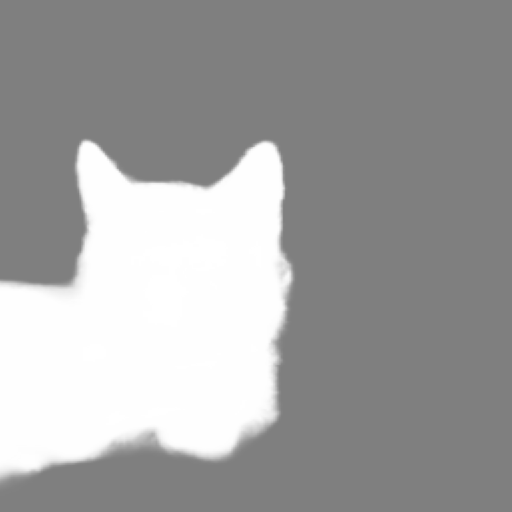

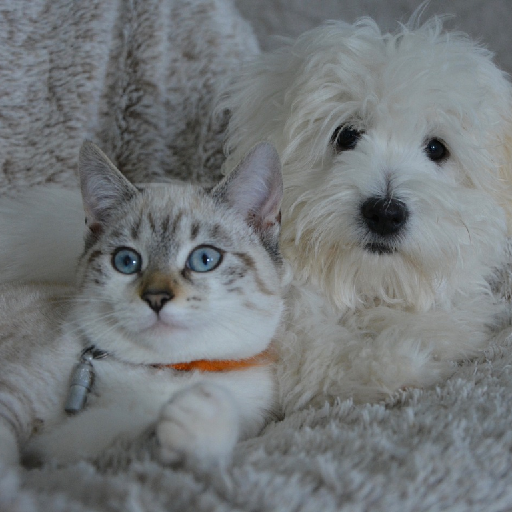

In [18]:

display_tensor(mask)
display_tensor(image)

In [9]:
# # display attention map
# from ptp.attention_map_display import show_cross_attention, show_self_attention_comp
# show_cross_attention(controller, res=int(IMAGE_SIZE/32), from_where=("up", "down"))

In [9]:
from ptp.ptp_utils import text_under_image, view_images

from typing import Optional, Union, Tuple, List, Callable, Dict
import torch
# from diffusers import StableDiffusionPipeline
import torch.nn.functional as nnf
import numpy as np
import abc
from ptp.ptp_attention_controllers import EmptyControl, AttentionStore
from PIL import Image
from torch import tensor
from torch.nn import functional as F


def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                # cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                cross_maps = item.reshape(
                    1, -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()

def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    # tokens = tokenizer.encode(prompts[select])
    # decoder = tokenizer.decode
    attention_maps = aggregate_attention(
        attention_store, res, from_where, True, select)
    images = []
    # for i in range(len(tokens)):
    for i in range(attention_maps.size(2)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        # image = text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    return view_images(np.stack(images, axis=0))


def show_self_attention_comp(attention_store: AttentionStore, res: int, from_where: List[str],
                             max_com=10, select: int = 0):
    attention_maps = aggregate_attention(
        attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(
        attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2),
                          3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    view_images(np.concatenate(images, axis=1))



def show_self_attention_maskpooling(attention_store: AttentionStore, res: int, from_where: List[str],
                                     select: int = 0, mask: tensor = None):
    attention_maps = aggregate_attention(
        attention_store, res, from_where, False, select).reshape((res ** 2, res ** 2))

    
    # 对角线元素设为0
    attention_maps = attention_maps - torch.diag(torch.diag(attention_maps))
    
    
    # filter
    mask[mask < 0.9] = 0
    mask[mask >= 0.9] = 1
    mask = -1 * mask
    kernel_size = mask.shape[1] // res
    mask = F.max_pool2d(mask, kernel_size=kernel_size, stride=kernel_size, padding=0)
    index = mask == -1
    index = index.reshape(-1).cpu()

    attention_maps = attention_maps[:,index]
    attention_maps = attention_maps.permute(1,0)

    
    attention_maps = attention_maps.numpy()
    # dim 0 random shuffle
    # attention_maps = attention_maps[np.random.permutation(attention_maps.shape[0])]
    images = []
    for i in range(len(attention_maps)):
        image = attention_maps[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max() if image.max() != 0 else 255 * image/ (image.max()+1e-5)
        
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    # show attention map for per token
    view_images(np.concatenate(images, axis=1))
    
    images = []
    # average images and view
    for i in range(len(attention_maps)):
        image = attention_maps[i].reshape(res, res)

        image = np.array(image)
        images.append(image)
    images = np.stack(images, axis=0)
    images = np.mean(images, axis=0)
    images = images - images.min()
    images =  255*images / images.max() if images.max() != 0 else 255 * images/ (images.max()+1e-5)
    
    images = images.astype('uint8')

    display(Image.fromarray(images).resize((256, 256)))

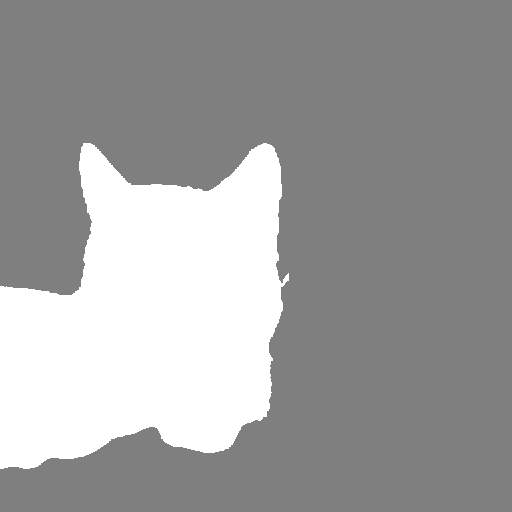

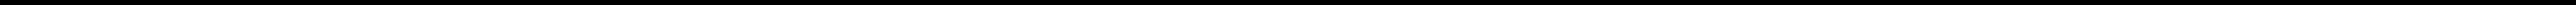

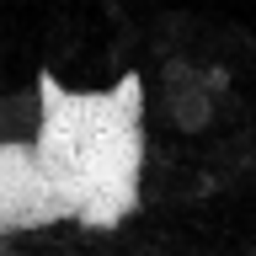

In [12]:
RES = int(IMAGE_SIZE/16) # 16 32
display_tensor(mask)

# show_self_attention_comp(controller, res=RES, from_where=["down", "mid", "up"], max_com=64, select=0)

show_self_attention_maskpooling(controller, res=RES, from_where=["down", "mid", "up"], select=0, mask=mask)

In [ ]:
def calculate_attention_score_(mask, attention_map, score_type):
    '''
    Calculate the attention score of the attention map
    mask: [H, W] value:0 or 1
    attention_map: [H*W, H, W]
    '''
    H, W = mask.shape
    mask_pos = mask.repeat(attention_map.shape[0], 1, 1)
    score_pos = torch.sum(attention_map * mask_pos, dim=(1,2))
    score_pos = score_pos / torch.sum(mask_pos, dim=(1,2))
    
    mask_neg = 1 - mask_pos
    score_neg = torch.sum(attention_map * mask_neg, dim=(1,2))
    score_neg = score_neg / torch.sum(mask_neg, dim=(1,2))
    
    assert score_type in ['classification', 'softmax', 'ratio']

    if score_type == 'classification':
        score = torch.zeros_like(score_pos)
        score[score_pos > score_neg] = 1
    elif score_type == 'softmax':
        score = torch.softmax(torch.stack([score_pos, score_neg], dim=1), dim=1)[:, 0]
        score[score>0.55]=1
        a = score.max()
        b = score.min()
        score[score<0.45]=0
        a = score.max()
        b = score.min()
        # set tensor score 大于0.45小于0.55的值为0.5
        score = torch.where((score>=0.45) & (score<=0.55), 0.5, score)
        
        a = score.max()
        b = score.min()
        assert score.min() != score.max()
    elif score_type == 'ratio':
        score = score_pos / score_neg
    
    return score.reshape(H, W)

In [ ]:

def calculate_attention_score(mask, controller, res, score_type, iterations=2):

    # get attention maps
    attention_maps = aggregate_attention(
        controller,res=res, from_where=["down", "mid", "up"], is_cross=False, select=0).reshape((res ** 2, res ** 2))

    # attention_maps = attention_maps - torch.diag(torch.diag(attention_maps))
    attention_maps = attention_maps.permute(1,0).reshape((-1, res, res))
    attention_maps = attention_maps.cuda()

    # get mask
    mask[mask < 1] = 0
    mask = -1 * mask
    kernel_size = mask.shape[1] // res
    mask = F.max_pool2d(mask, kernel_size=kernel_size, stride=kernel_size, padding=0)
    mask = -255*mask
    mask = mask.squeeze()
    
    display_tensor(mask, type='gray')
    
    mask = mask.cuda()/255.0 # [res, res]
    
    # visualize mask
    image_size = image.shape[2]
    mask_ = F.interpolate(mask.float().unsqueeze(0).unsqueeze(0), size=(image_size,image_size), mode='nearest')
    display_tensor(mask_*image)
    print(mask.shape)
    
    for i in range(iterations):
        score = calculate_attention_score_(mask, attention_maps, score_type = score_type) # [res, res]
        
        
        display_tensor(score, type='gray')
        
        
        
        score_ = F.interpolate(score.float().unsqueeze(0).unsqueeze(0), size=(image_size,image_size), mode='nearest')

        print(score.shape)
        display_tensor(score_*image)
        
        if score.equal(mask):
            print("iteration: ", i, "score equal to mask")
            break
        else:
            mask = score

    

if using attention_map after softmax, score_pos and score_neg fall around 0.5.
score_type = softmax is not ok.

In [ ]:
calculate_attention_score(mask, controller, res=RES, score_type = "classification", iterations=1000)

In [ ]:
from PIL import Image
import numpy as np
import torch
def read_mask_raw(dir):
    # read a gray image
    mask_raw = Image.open(dir).convert('L')
    mask_raw = np.array(mask_raw)
    mask_raw = mask_raw/255.0
    mask_raw = torch.from_numpy(mask_raw).unsqueeze(0).float().cuda()
    return mask_raw

In [ ]:
dir = 'mask_raw.png'
mask_raw = read_mask_raw(dir)
calculate_attention_score(mask_raw, controller, res=RES, score_type = "classification", iterations=200)

In [ ]:
# 迭代refine mask
# 对于point or 点划线，通过ref_image的self-attention扩充，或者直接通过迭代？